In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from statsmodels.tsa.stattools import adfuller

#### IMPORT DATA AND ESTABLISH START AND END DATES ####

In [2]:
# Create the foundational dataset
df = pd.read_csv('grocery_dataset_eda.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[(df['date'] >= '2005-01-01') & (df['date'] <= '2025-01-01')]
df = df.reset_index().set_index('date').drop(columns = 'index')

In [3]:
# Rename variables
df = df.rename(columns={"US Grocery Sales": 'us_grocery_sales',  
        "CPI (Food at Home)": 'cpi_fah',
        "Real Disposable Income adj": 'rdi',
        "Avg Home Price": "avg_home_price",
        "US Grocery Sales_lag1": 'us_grocery_sales_lag1'})

#### CHECK FOR MISSING VALUES ####

In [4]:
# Nothing kills a regression faster than missing data
vars = ['us_grocery_sales', 'us_grocery_sales_lag1', 'cpi_fah', 'rdi', 'avg_home_price', 'covid1', 'covid2']

# Count total missing values per column
missing_counts = df[vars].isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

Series([], dtype: int64)

In [5]:
# Fill in missing data or the reg won't run
df['avg_home_price'] = df['avg_home_price'].ffill()

#### BUILD THE MODEL AND MERGE WITHIN SAMPLE BACK TO DF ####

In [6]:
# Define independent (X) and dependent (y) variables
X = df[['us_grocery_sales_lag1', 'cpi_fah', 'rdi', 'avg_home_price', 'covid1', 'covid2']]
y = df['us_grocery_sales']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) regression model
model = sm.OLS(y, X).fit()

# Print detailed statistical summary
print(model.summary())

# merge fitted values onto dh.  We don't need to merge because the row indices are the same
df['us_grocery_sales_fcst'] = model.fittedvalues
df['us_grocery_sales_resid'] = model.resid

                            OLS Regression Results                            
Dep. Variable:       us_grocery_sales   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.820e+04
Date:                Sat, 29 Mar 2025   Prob (F-statistic):          2.86e-309
Time:                        11:16:41   Log-Likelihood:                -1849.5
No. Observations:                 241   AIC:                             3713.
Df Residuals:                     234   BIC:                             3737.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.109e+

#### VISUALS AND DIAGNOSTICS ####

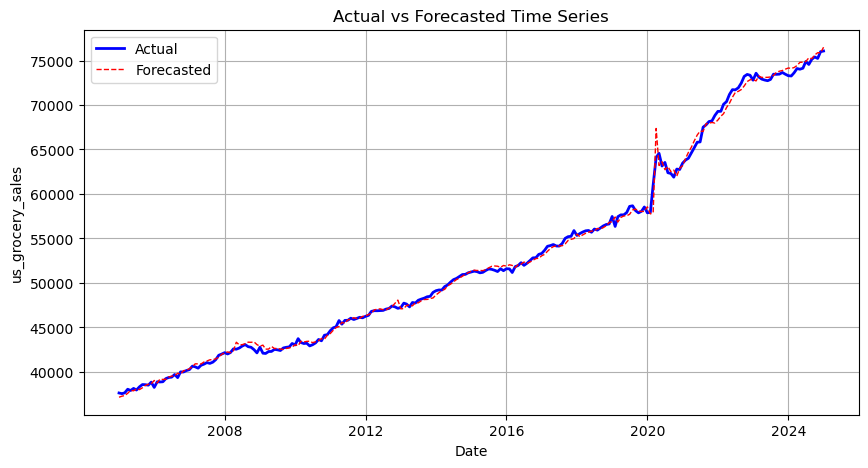

In [7]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x=df.index, y='us_grocery_sales', label='Actual', linewidth=2, color='blue')
sns.lineplot(data=df, x=df.index, y='us_grocery_sales_fcst', label='Forecasted', linewidth=1, color='red', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('us_grocery_sales')
plt.title('Actual vs Forecasted Time Series')
plt.legend()
plt.grid(True)

plt.show()

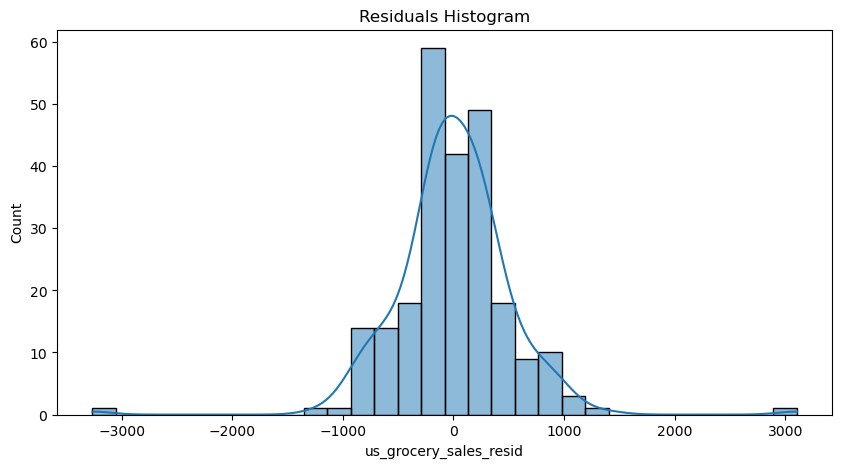

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(df["us_grocery_sales_resid"], bins=30, kde=True)
plt.title('Residuals Histogram')
plt.show()

<Figure size 1000x500 with 0 Axes>

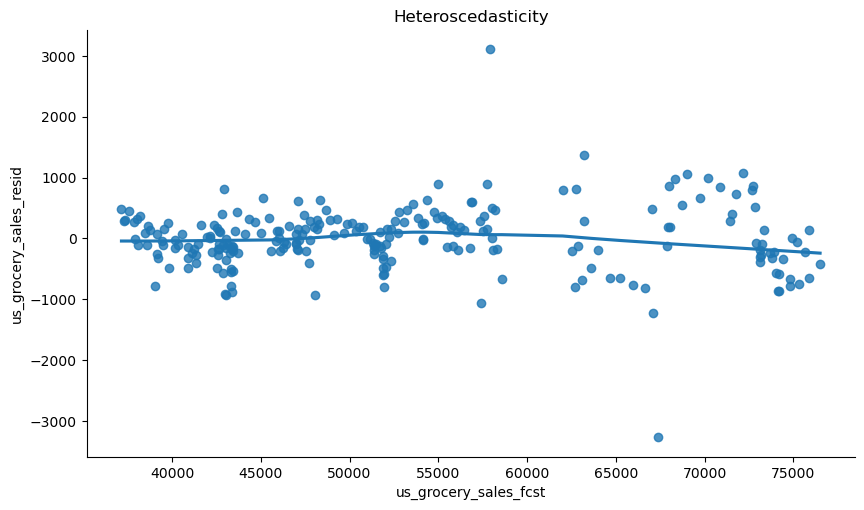

In [9]:
plt.figure(figsize=(10, 5))
sns.lmplot(x="us_grocery_sales_fcst", y="us_grocery_sales_resid", data=df, lowess=True, aspect=1.75, height=5)
plt.title('Heteroscedasticity')
plt.show()

In [10]:
# Step 1: Add a constant column (intercept)
X = sm.add_constant(X)

# Step 2: Initialize an empty list to store VIF values
vif_list = []

# Step 3: Loop through each feature and compute VIF
for i in range(X.shape[1]):  # Loop over each column index
    vif_value = variance_inflation_factor(X.values, i)  # Compute VIF for the column
    vif_list.append((X.columns[i], vif_value))  # Store (Feature Name, VIF Value)

# Step 4: Convert results into a DataFrame
vif_data = pd.DataFrame(vif_list, columns=["Feature", "VIF"])
vif_data

,Feature,VIF
0,const,626.329312
1,us_grocery_sales_lag1,108.978578
2,cpi_fah,26.623353
3,rdi,26.745210
4,avg_home_price,7.428951
5,covid1,1.258958
6,covid2,1.247969


#### GET SE MEAN AND CONFIDENCE INTERVALS ####

In [11]:
# Ensure X includes the same predictors used in training

# Get predictions and confidence intervals
predictions = model.get_prediction(X)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

# Store confidence intervals
df['us_grocery_sales_se_mean'] = pred_summary['mean_se']  # SE of the mean
df['us_grocery_sales_se_lower'] = pred_summary['mean_ci_lower']  # SE of the mean
df['us_grocery_sales_se_upper'] = pred_summary['mean_ci_upper']  # SE of the mean
df['lower_bound'] = pred_summary['obs_ci_lower']  # SE of the mean
df['upper_bound'] = pred_summary['obs_ci_upper']  # SE of the mean

# ✅ Compute SE of the estimate (obs_se) using the upper and lower columns 
df['us_grocery_sales_se_obs'] = (df['upper_bound'] - df['lower_bound']) / (2 * 1.96)  # 95% CI

# # Show first few rows
df[['us_grocery_sales_fcst', 'us_grocery_sales_se_mean', 'us_grocery_sales_se_obs', 'us_grocery_sales_se_lower', 'us_grocery_sales_se_upper', 
    'lower_bound', 'upper_bound']].head()

,us_grocery_sales_fcst,us_grocery_sales_se_mean,us_grocery_sales_se_obs,us_grocery_sales_se_lower,us_grocery_sales_se_upper,lower_bound,upper_bound
date,,,,,,,
2005-01-01,37151.276587,85.060509,538.121303,36983.694315,37318.858858,36096.558832,38205.994341
2005-02-01,37270.092208,89.016603,538.767442,37094.715822,37445.468594,36214.108022,38326.076394
2005-03-01,37341.180691,86.744702,538.392882,37170.280302,37512.081081,36285.930642,38396.430741
2005-04-01,37592.859214,83.677410,537.902158,37428.001859,37757.716569,36538.570984,38647.147444
2005-05-01,37925.165068,85.846775,538.247444,37756.033732,38094.296404,36870.200077,38980.130060


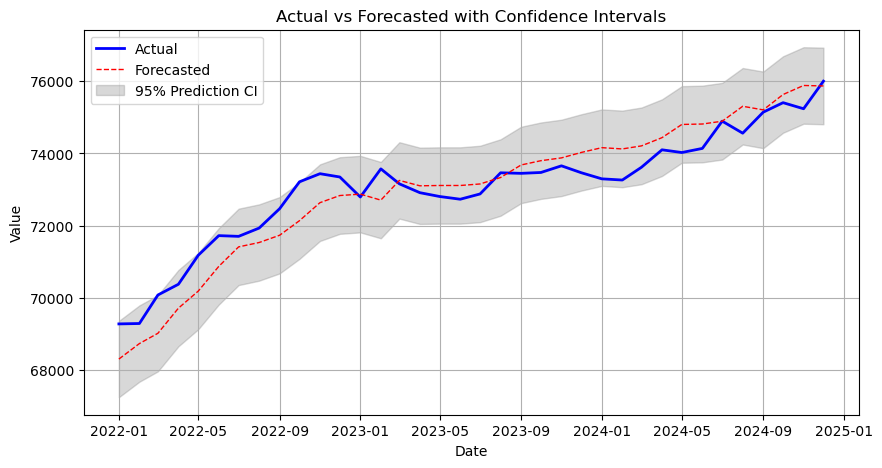

In [12]:
#Define the start and end date for filtering
start_date = '2022-01-01'
end_date = '2024-12-31'

#Filter the DataFrame to only include the desired months
df_subset = df.loc[start_date:end_date]
df_subset

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_subset, x=df_subset.index, y=df_subset['us_grocery_sales'], label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_subset, x=df_subset.index, y='us_grocery_sales_fcst', label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')

plt.fill_between(df_subset.index, df_subset['lower_bound'], df_subset['upper_bound'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()


#### FORWARD FORECAST - ESTIMATE THE INPUTS AND BUILD THE FILE ####

In [13]:
#Independent forward forecast estimates

cpi_fah_dic = {pd.Timestamp('2025-02-01'): 1.8, pd.Timestamp('2025-03-01'): 2.0, pd.Timestamp('2025-04-01'): 2.2, pd.Timestamp('2025-05-01'): 2.4,
                pd.Timestamp('2025-06-01'): 2.6, pd.Timestamp('2025-07-01'): 2.8, pd.Timestamp('2025-08-01'): 3.0, pd.Timestamp('2025-09-01'): 3.2, 
                pd.Timestamp('2025-10-01'): 3.4, pd.Timestamp('2025-11-01'): 3.6, pd.Timestamp('2025-12-01'): 3.8}

rdi_dic = {pd.Timestamp('2025-02-01'): 2, pd.Timestamp('2025-03-01'): 2, pd.Timestamp('2025-04-01'): 2, pd.Timestamp('2025-05-01'): 2,
                pd.Timestamp('2025-06-01'): 2, pd.Timestamp('2025-07-01'): 1.7, pd.Timestamp('2025-08-01'): 1.7, pd.Timestamp('2025-09-01'): 1.7, 
               pd.Timestamp('2025-10-01'): 1.7, pd.Timestamp('2025-11-01'): 1.7, pd.Timestamp('2025-12-01'): 1.7}

home_price_dic = {pd.Timestamp('2025-02-01'): 2, pd.Timestamp('2025-03-01'): 2, pd.Timestamp('2025-04-01'): 2, pd.Timestamp('2025-05-01'): 2,
                pd.Timestamp('2025-06-01'): 2, pd.Timestamp('2025-07-01'): 2, pd.Timestamp('2025-08-01'): 2, pd.Timestamp('2025-09-01'): 2, 
                  pd.Timestamp('2025-10-01'): 2, pd.Timestamp('2025-11-01'): 2, pd.Timestamp('2025-12-01'): 2}

In [14]:
# Define the forward forecast period and build the file

# Build the df based on the date range.  The months become the index
forecast_months = pd.date_range("2025-02-01", "2025-12-01", freq="MS")
forward_df = pd.DataFrame(index=forecast_months)

# Fill in known inputs by defining the previous year values so we can estimate the YOY values for the forecast
# THis loop grabs last years value and then applies the growth rate to calculate the future input value
# date and prev_year are the outputs that are inserted into the formulas below
for date in forecast_months:
    prev_year = date - pd.DateOffset(years=1)  
    
    forward_df.loc[date, "cpi_fah"] = df.loc[prev_year, "cpi_fah"] * (1 + cpi_fah_dic[date] / 100)
    forward_df.loc[date, "rdi"] = df.loc[prev_year, "rdi"] * (1 + rdi_dic[date] / 100)
    forward_df.loc[date, "avg_home_price"] = df.loc[prev_year, "avg_home_price"] * (1 + home_price_dic[date] / 100)

# Initialize lag variable
last_known_value = df.loc["2025-01-01", "us_grocery_sales"]
forward_df["us_grocery_sales_lag1"] = np.nan
forward_df.loc[forecast_months[0], "us_grocery_sales_lag1"] = last_known_value

# Add empty columns for forecast and intervals
forward_df["covid1"] = 0
forward_df["covid2"] = 0
forward_df["us_grocery_sales"] = np.nan
forward_df["us_grocery_sales_fcst"] = np.nan

# Pull the last 11 months of SE values (assumed to be Feb–Dec 2024)
se_obs_values = df['us_grocery_sales_se_obs'].iloc[-12:-1].copy()  # Or use .loc["2024-02-01":"2024-12-01"]

# Shift the index forward to 2025
se_obs_values.index = se_obs_values.index + pd.DateOffset(years=1)

# Assign these shifted SE values into forward_df
forward_df['us_grocery_sales_se_obs'] = se_obs_values

forward_df

,cpi_fah,rdi,avg_home_price,us_grocery_sales_lag1,covid1,covid2,us_grocery_sales,us_grocery_sales_fcst,us_grocery_sales_se_obs
2025-02-01,311.080440,17791.2480,319.03662,76071.0,0,0,NaN,NaN,540.485447
2025-03-01,311.474340,17836.6380,323.30430,NaN,0,0,NaN,NaN,541.387658
2025-04-01,312.014556,17814.1980,327.30372,NaN,0,0,NaN,NaN,540.963537
2025-05-01,312.609792,17861.3220,330.29028,NaN,0,0,NaN,NaN,540.472988
2025-06-01,313.608186,17865.9120,331.86924,NaN,0,0,NaN,NaN,541.132329
2025-07-01,314.563888,17802.5850,332.19054,NaN,0,0,NaN,NaN,541.062762
2025-08-01,315.426170,17792.0082,331.62954,NaN,0,0,NaN,NaN,539.827461
2025-09-01,317.031432,17817.4332,331.25010,NaN,0,0,NaN,NaN,540.625377
2025-10-01,318.263132,17883.6399,330.56466,NaN,0,0,NaN,NaN,539.903171
2025-11-01,320.000716,17918.3196,330.25968,NaN,0,0,NaN,NaN,539.936179


In [15]:
for col in forward_df.columns:
    print(col)

cpi_fah
rdi
avg_home_price
us_grocery_sales_lag1
covid1
covid2
us_grocery_sales
us_grocery_sales_fcst
us_grocery_sales_se_obs


In [16]:
sales_coef = {name: value for name, value in model.params.items()}
sales_coef

{'const': -11089.487759515763,
 'us_grocery_sales_lag1': 0.5548536076993664,
 'cpi_fah': 64.351995164106,
 'rdi': 1.1470744549478935,
 'avg_home_price': 15.576222757546724,
 'covid1': -560.9192526564402,
 'covid2': 674.3034488556896}

In [17]:
const = sales_coef['const']
us_grocery_sales_lag1 = sales_coef['us_grocery_sales_lag1']
cpi_fah = sales_coef['cpi_fah']
rdi = sales_coef['rdi']
avg_home_price = sales_coef['avg_home_price']
covid1 = sales_coef['covid1']
covid2 = sales_coef['covid2']

In [18]:
# Initialize values before the loop
forecasted_sales = []
lower_ci = []
upper_ci = []
lagged_sales = []

last_sales = df['us_grocery_sales'].iloc[-1]

# Loop through each row in forward_df
for i, row in forward_df.iterrows():
    y_hat = (
        const +
        us_grocery_sales_lag1 * last_sales +
        cpi_fah * row["cpi_fah"] +
        rdi * row["rdi"] +
        avg_home_price * row["avg_home_price"] +
        covid1 * row['covid1'] +
        covid2 * row['covid2']
    )

    forecasted_sales.append(round(y_hat, 2))

    # Calculate and store confidence intervals
    se = row["us_grocery_sales_se_obs"]
    lower_ci.append(y_hat - 1.96 * se)
    upper_ci.append(y_hat + 1.96 * se)
    lagged_sales.append(last_sales)

    last_sales = y_hat  # update for next iteration

# Assign all lists to the DataFrame
forward_df['us_grocery_sales_fcst'] = forecasted_sales
forward_df['lower_bound'] = lower_ci
forward_df['upper_bound'] = upper_ci
forward_df['us_grocery_sales_lag1'] = lagged_sales

In [19]:
forward_df

,cpi_fah,rdi,avg_home_price,us_grocery_sales_lag1,covid1,covid2,us_grocery_sales,us_grocery_sales_fcst,us_grocery_sales_se_obs,lower_bound,upper_bound
2025-02-01,311.080440,17791.2480,319.03662,76071.000000,0,0,NaN,76514.70,540.485447,75455.348090,77574.051041
2025-03-01,311.474340,17836.6380,323.30430,76514.699566,0,0,NaN,76904.78,541.387658,75843.656356,77965.895974
2025-04-01,312.014556,17814.1980,327.30372,76904.776165,0,0,NaN,77192.53,540.963537,76132.242525,78252.819589
2025-05-01,312.609792,17861.3220,330.29028,77192.531057,0,0,NaN,77491.07,540.472988,76431.744526,78550.398637
2025-06-01,313.608186,17865.9120,331.86924,77491.071582,0,0,NaN,77750.83,541.132329,76690.206455,78811.445183
2025-07-01,314.563888,17802.5850,332.19054,77750.825819,0,0,NaN,77888.82,541.062762,76828.333568,78949.299595
2025-08-01,315.426170,17792.0082,331.62954,77888.816582,0,0,NaN,78000.00,539.827461,76941.938359,79058.062007
2025-09-01,317.031432,17817.4332,331.25010,78000.000183,0,0,NaN,78188.25,540.625377,77128.621006,79247.872483
2025-10-01,318.263132,17883.6399,330.56466,78188.246744,0,0,NaN,78437.23,539.903171,77379.015614,79495.436042
2025-11-01,320.000716,17918.3196,330.25968,78437.225828,0,0,NaN,78722.22,539.936179,77663.944618,79780.494442


In [20]:
# Stack the df and forward df
df_subset = df[forward_df.columns]
df_subset = pd.concat([df_subset, forward_df], axis=0)
df_subset

,cpi_fah,rdi,avg_home_price,us_grocery_sales_lag1,covid1,covid2,us_grocery_sales,us_grocery_sales_fcst,us_grocery_sales_se_obs,lower_bound,upper_bound
2005-01-01,188.100000,11226.5000,160.13100,37423.000000,0,0,37628.0,37151.276587,538.121303,36096.558832,38205.994341
2005-02-01,187.700000,11229.0000,161.92500,37628.000000,0,0,37553.0,37270.092208,538.767442,36214.108022,38326.076394
2005-03-01,188.100000,11268.8000,164.57700,37553.000000,0,0,37645.0,37341.180691,538.392882,36285.930642,38396.430741
2005-04-01,190.000000,11304.2000,167.00100,37645.000000,0,0,38049.0,37592.859214,537.902158,36538.570984,38647.147444
2005-05-01,190.200000,11352.7000,169.54600,38049.000000,0,0,37908.0,37925.165068,538.247444,36870.200077,38980.130060
...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01,315.426170,17792.0082,331.62954,77888.816582,0,0,NaN,78000.000000,539.827461,76941.938359,79058.062007
2025-09-01,317.031432,17817.4332,331.25010,78000.000183,0,0,NaN,78188.250000,540.625377,77128.621006,79247.872483
2025-10-01,318.263132,17883.6399,330.56466,78188.246744,0,0,NaN,78437.230000,539.903171,77379.015614,79495.436042
2025-11-01,320.000716,17918.3196,330.25968,78437.225828,0,0,NaN,78722.220000,539.936179,77663.944618,79780.494442


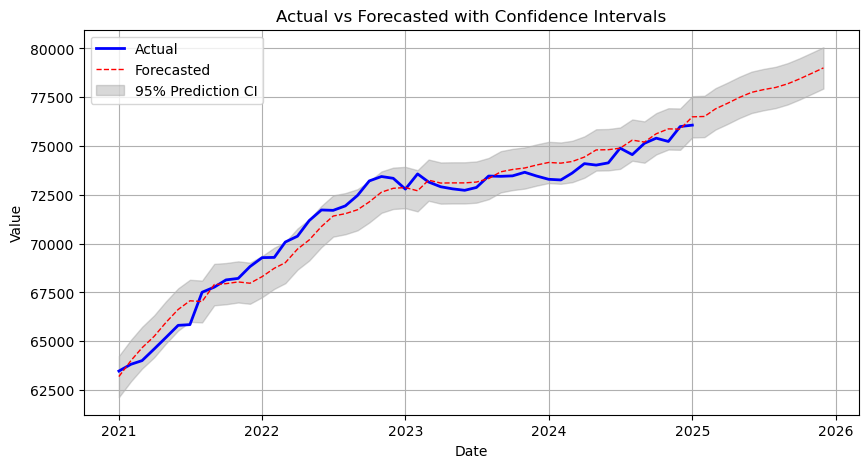

In [21]:
#Define the start and end date for filtering
start_date = '2021-01-01'
end_date = '2025-12-01'

#Filter the DataFrame to only include the desired months
df_chart = df_subset.loc[start_date:end_date]

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_chart, x=df_chart.index, y=df_chart['us_grocery_sales'], label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_chart, x=df_chart.index, y=df_chart['us_grocery_sales_fcst'], label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')

plt.fill_between(df_chart.index, df_chart['lower_bound'], df_chart['upper_bound'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()

In [22]:
df_monthly = df_subset.sort_index()
df_monthly.index = pd.to_datetime(df_monthly.index)

df_monthly["us_grocery_sales"] = df_monthly["us_grocery_sales"].fillna(df_monthly["us_grocery_sales_fcst"])

df_monthly["Actual YOY %"] = df_monthly["us_grocery_sales"].pct_change(periods=12) * 100
df_monthly["Forecast YOY %"] = df_monthly["us_grocery_sales_fcst"].pct_change(periods=12) * 100

df_monthly["Actual YOY Change"] = df_monthly["us_grocery_sales"].diff(periods=12)
df_monthly["Forecast YOY Change"] = df_monthly["us_grocery_sales_fcst"].diff(periods=12)

df_monthly


,cpi_fah,rdi,avg_home_price,us_grocery_sales_lag1,covid1,covid2,us_grocery_sales,us_grocery_sales_fcst,us_grocery_sales_se_obs,lower_bound,upper_bound,Actual YOY %,Forecast YOY %,Actual YOY Change,Forecast YOY Change
2005-01-01,188.100000,11226.5000,160.13100,37423.000000,0,0,37628.00,37151.276587,538.121303,36096.558832,38205.994341,NaN,NaN,NaN,NaN
2005-02-01,187.700000,11229.0000,161.92500,37628.000000,0,0,37553.00,37270.092208,538.767442,36214.108022,38326.076394,NaN,NaN,NaN,NaN
2005-03-01,188.100000,11268.8000,164.57700,37553.000000,0,0,37645.00,37341.180691,538.392882,36285.930642,38396.430741,NaN,NaN,NaN,NaN
2005-04-01,190.000000,11304.2000,167.00100,37645.000000,0,0,38049.00,37592.859214,537.902158,36538.570984,38647.147444,NaN,NaN,NaN,NaN
2005-05-01,190.200000,11352.7000,169.54600,38049.000000,0,0,37908.00,37925.165068,538.247444,36870.200077,38980.130060,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01,315.426170,17792.0082,331.62954,77888.816582,0,0,78000.00,78000.000000,539.827461,76941.938359,79058.062007,4.615137,3.580762,3441.00,2696.441389
2025-09-01,317.031432,17817.4332,331.25010,78000.000183,0,0,78188.25,78188.250000,540.625377,77128.621006,79247.872483,4.056761,3.968785,3048.25,2984.668514
2025-10-01,318.263132,17883.6399,330.56466,78188.246744,0,0,78437.23,78437.230000,539.903171,77379.015614,79495.436042,4.024018,3.713746,3034.23,2808.653102
2025-11-01,320.000716,17918.3196,330.25968,78437.225828,0,0,78722.22,78722.220000,539.936179,77663.944618,79780.494442,4.635103,3.747517,3487.22,2843.565444


In [23]:
df_annual = df_monthly.groupby(df_subset.index.year)[["us_grocery_sales", "us_grocery_sales_fcst"]].sum()

df_annual["Actual YOY %"] = df_annual["us_grocery_sales"].pct_change() * 100
df_annual["Forecast YOY %"] = df_annual["us_grocery_sales_fcst"].pct_change() * 100

df_annual["Actual YOY Change"] = df_annual["us_grocery_sales"].diff()
df_annual["Forecast YOY Change"] = df_annual["us_grocery_sales_fcst"].diff()

df_annual = df_annual.round(2)  # Optional: round for cleaner viewing

df_annual

,us_grocery_sales,us_grocery_sales_fcst,Actual YOY %,Forecast YOY %,Actual YOY Change,Forecast YOY Change
2005,457697.00,455190.49,NaN,NaN,NaN,NaN
2006,472130.00,473702.66,3.15,4.07,14433.00,18512.17
2007,491835.00,493771.88,4.17,4.24,19705.00,20069.22
2008,510355.00,514592.12,3.77,4.22,18520.00,20820.24
2009,510394.00,512365.92,0.01,-0.43,39.00,-2226.20
2010,521151.00,521381.46,2.11,1.76,10757.00,9015.54
2011,547528.00,546224.78,5.06,4.76,26377.00,24843.32
2012,562996.00,564700.17,2.83,3.38,15468.00,18475.39
2013,575841.00,572985.92,2.28,1.47,12845.00,8285.74
2014,601640.00,599439.38,4.48,4.62,25799.00,26453.46


In [24]:
df_monthly.to_csv('grocery_forecast_month.csv')
df_annual.to_csv('grocery_forecast_annual.csv')